## Import Utils

In [1]:
!pip install keras

In [2]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = 'data/train/eightieth.h5'
PATH_PREDICT_WITHOUT_GT = 'data/pred_students/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'test.h5'
PATH_PREDICT_WITH_GT = 'data/pred_teachers/pred_eighties_from_half_1.h5'

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Reshape, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [4]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [5]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [6]:
import pywt
import cv2


def generator_histogram(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            for bb in batch_idxs:
                patch = f['S2'][bb, :,:,:]
                
                # dwt2 for each chan
                cA0, (cD0, cV0, cH0) = pywt.dwt2(f['S2'][bb, :,:,0], 'haar')
                cA1, (cD1, cV1, cH1) = pywt.dwt2(f['S2'][bb, :,:,1], 'haar')
                cA2, (cD2, cV2, cH2) = pywt.dwt2(f['S2'][bb, :,:,2], 'haar')
                cA3, (cD3, cV3, cH3) = pywt.dwt2(f['S2'][bb, :,:,3], 'haar')
                
                dwt2 = np.zeros((16,16,4))
                dwt2[:,:,0] = np.concatenate((np.concatenate((cA0, cD0), axis=1), np.concatenate((cV0, cH0), axis=1)), axis=0)
                dwt2[:,:,1] = np.concatenate((np.concatenate((cA1, cD1), axis=1), np.concatenate((cV1, cH1), axis=1)), axis=0)
                dwt2[:,:,2] = np.concatenate((np.concatenate((cA2, cD2), axis=1), np.concatenate((cV2, cH2), axis=1)), axis=0)
                dwt2[:,:,3] = np.concatenate((np.concatenate((cA3, cD3), axis=1), np.concatenate((cV3, cH3), axis=1)), axis=0)
                
                fft2 = np.zeros((16,16,4))
                fft2[:,:,0] = np.real(np.fft.fft2(f['S2'][bb, :,:,0]))
                fft2[:,:,1] = np.real(np.fft.fft2(f['S2'][bb, :,:,1]))
                fft2[:,:,2] = np.real(np.fft.fft2(f['S2'][bb, :,:,2]))
                fft2[:,:,3] = np.real(np.fft.fft2(f['S2'][bb, :,:,3]))
                
                
                tmp1 = np.zeros((16,16,12))
                tmp1[:,:,0] = patch[:,:,0]
                tmp1[:,:,1] = patch[:,:,1]
                tmp1[:,:,2] = patch[:,:,2]
                tmp1[:,:,3] = patch[:,:,3]
                tmp1[:,:,4] = dwt2[:,:,0]
                tmp1[:,:,5] = dwt2[:,:,1]
                tmp1[:,:,6] = dwt2[:,:,2]
                tmp1[:,:,7] = dwt2[:,:,3]
                tmp1[:,:,8] = fft2[:,:,0]
                tmp1[:,:,9] = fft2[:,:,1]
                tmp1[:,:,10] = fft2[:,:,2]
                tmp1[:,:,11] = fft2[:,:,3]
                X.append(tmp1)
                
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [7]:
train_gen = generator_histogram(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator_histogram(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)
print(train_batch_count, val_batch_count)
print(np.shape(train_gen.__next__()[0])) 

5850 1463
(32, 16, 16, 12)


# Instanciation du model

In [8]:
input_shape = (16,16,12)
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(23, activation='softmax'))

In [9]:
#optim = keras.optimizers.Adam(lr=0.001)
#optim = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#optim = keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.0)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 16, 16, 12)        48        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1744      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               819328    
__________

In [10]:
history = model.fit_generator(train_gen, steps_per_epoch=train_batch_count/BATCH_SIZE, epochs=10, verbose=1, 
                              validation_data=val_gen, validation_steps=val_batch_count/BATCH_SIZE)
model.save_weights(PATH_SUBMIT)

Epoch 1/10
183/182 [==============================] - 58s 314ms/step - loss: 1.5109 - categorical_accuracy: 0.4617 - val_loss: 1.3348 - val_categorical_accuracy: 0.5136
Epoch 2/10
183/182 [==============================] - 57s 311ms/step - loss: 1.3375 - categorical_accuracy: 0.5029 - val_loss: 1.2373 - val_categorical_accuracy: 0.5611
Epoch 3/10
183/182 [==============================] - 57s 313ms/step - loss: 1.2900 - categorical_accuracy: 0.5212 - val_loss: 1.2398 - val_categorical_accuracy: 0.5279
Epoch 4/10
183/182 [==============================] - 61s 333ms/step - loss: 1.2546 - categorical_accuracy: 0.5405 - val_loss: 1.1521 - val_categorical_accuracy: 0.5693
Epoch 5/10
183/182 [==============================] - 58s 314ms/step - loss: 1.2675 - categorical_accuracy: 0.5304 - val_loss: 1.2256 - val_categorical_accuracy: 0.5319
Epoch 6/10
183/182 [==============================] - 63s 343ms/step - loss: 1.2478 - categorical_accuracy: 0.5307 - val_loss: 1.1843 - val_categorical_acc

In [11]:
score = model.evaluate_generator(val_gen, steps=val_batch_count/BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1655640485494032
Test accuracy: 0.5373641304347826


## Prediction routines

In order to submit a result here are some gits

In [12]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = []
        for bb in batch_idxs:
            patch = f['S2'][bb, :,:,:]

            # dwt2 for each chan
            cA0, (cD0, cV0, cH0) = pywt.dwt2(f['S2'][bb, :,:,0], 'haar')
            cA1, (cD1, cV1, cH1) = pywt.dwt2(f['S2'][bb, :,:,1], 'haar')
            cA2, (cD2, cV2, cH2) = pywt.dwt2(f['S2'][bb, :,:,2], 'haar')
            cA3, (cD3, cV3, cH3) = pywt.dwt2(f['S2'][bb, :,:,3], 'haar')

            dwt2 = np.zeros((16,16,4))
            dwt2[:,:,0] = np.concatenate((np.concatenate((cA0, cD0), axis=1), np.concatenate((cV0, cH0), axis=1)), axis=0)
            dwt2[:,:,1] = np.concatenate((np.concatenate((cA1, cD1), axis=1), np.concatenate((cV1, cH1), axis=1)), axis=0)
            dwt2[:,:,2] = np.concatenate((np.concatenate((cA2, cD2), axis=1), np.concatenate((cV2, cH2), axis=1)), axis=0)
            dwt2[:,:,3] = np.concatenate((np.concatenate((cA3, cD3), axis=1), np.concatenate((cV3, cH3), axis=1)), axis=0)

            fft2 = np.zeros((16,16,4))
            fft2[:,:,0] = np.real(np.fft.fft2(f['S2'][bb, :,:,0]))
            fft2[:,:,1] = np.real(np.fft.fft2(f['S2'][bb, :,:,1]))
            fft2[:,:,2] = np.real(np.fft.fft2(f['S2'][bb, :,:,2]))
            fft2[:,:,3] = np.real(np.fft.fft2(f['S2'][bb, :,:,3]))

            tmp1 = np.zeros((16,16,12))
            tmp1[:,:,0] = patch[:,:,0]
            tmp1[:,:,1] = patch[:,:,1]
            tmp1[:,:,2] = patch[:,:,2]
            tmp1[:,:,3] = patch[:,:,3]
            tmp1[:,:,4] = dwt2[:,:,0]
            tmp1[:,:,5] = dwt2[:,:,1]
            tmp1[:,:,6] = dwt2[:,:,2]
            tmp1[:,:,7] = dwt2[:,:,3]
            tmp1[:,:,8] = fft2[:,:,0]
            tmp1[:,:,9] = fft2[:,:,1]
            tmp1[:,:,10] = fft2[:,:,2]
            tmp1[:,:,11] = fft2[:,:,3]

            X.append(tmp1)


        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [14]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 1694s 224ms/step
241700


1

## Some ideas for monitoring

In [15]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [16]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

Normalized confusion matrix


<IPython.core.display.Javascript object>


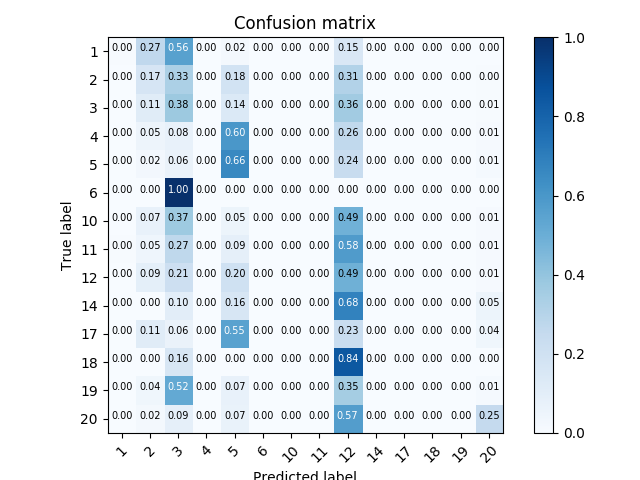

In [18]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)